In [1114]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import sklearn
import scipy
np.random.seed(0)

## Data loading

In [1115]:
cycleA = pd.read_csv("Data/Chickens data/CycleA-CleanData211122.csv", sep=";")
cycleB = pd.read_csv("Data/Chickens data/CycleB-CleanData211122.csv", sep=";")
cycleZ = pd.read_csv("Data/Chickens data/CycleZ-CleanData221122.csv", sep=";")

temperature_data = pd.read_csv("Data/Meteorological data/temperature_goito.csv", sep=",")
rain_data = pd.read_csv("Data/Meteorological data/rain_goito.csv", sep=",")
humidity_data = pd.read_csv("Data/Meteorological data/humidity_ponte_sul_mincio.csv", sep=",")

eggs_price = pd.read_csv("Data\EggsData\eggsPrice.csv", sep=";")

eggs_price

MarketingYear ReferencePeriod  WeekNo MemberState FarmingMethod  \
0              2022      07/11/2022      45       Italy          Barn   
1              2022      07/11/2022      45       Italy          Cage   
2              2022      31/10/2022      44       Italy          Barn   
3              2022      31/10/2022      44       Italy          Cage   
4              2022      24/10/2022      43       Italy          Barn   
...             ...             ...     ...         ...           ...   
1416           1997      03/02/1997       5       Italy          Cage   
1417           1997      27/01/1997       4       Italy          Cage   
1418           1997      20/01/1997       3       Italy          Cage   
1419           1997      13/01/1997       2       Italy          Cage   
1420           1997      06/01/1997       1       Italy          Cage   

      Price(euro/100kg)  
0                301.59  
1                264.68  
2                301.59  
3                264.68  
4                301.59  
...                 ...  
1416             120.62  
1417             120.62  
1418             120.62  
1419             123.03  
1420             131.88  

[1421 rows x 6 columns]

## Data cleaning

In [1116]:
# # removing rows with Nan values from chickens data
# cycleA = cycleA.dropna()
# cycleB = cycleB.dropna()
# # cycleZ = cycleZ.dropna()

# removing rows with non valid data from temperature_data
temperature_data = temperature_data[temperature_data["Avg_temp_value"] != -999.0]
#removing sensor id column
temperature_data.pop('Sensor_ID')
temperature_data.pop('Min_temp_value')
temperature_data.pop('Max_temp_value')

# removing rows with non valid data from humidity_data
humidity_data = humidity_data[humidity_data["Avg_humidity_value"] != -999.0]
#removing sensor id column
humidity_data.pop('Sensor_ID')
humidity_data.pop('Min_humidity_value')
humidity_data.pop('Max_humidity_value')

# modifying data format of chickens data for uniformity: YYYY/MM/DD
cycleA['Arrival Chickens Date'] = pd.to_datetime(cycleA["Arrival Chickens Date"], dayfirst=True).dt.strftime('%Y/%m/%d')
cycleA['Date of Laid'] = pd.to_datetime(cycleA["Date of Laid"], dayfirst=True).dt.strftime('%Y/%m/%d')
cycleA['Date of Selling'] = pd.to_datetime(cycleA["Date of Selling"], dayfirst=True).dt.strftime('%Y/%m/%d')
cycleB['Arrival Chickens Date'] = pd.to_datetime(cycleB["Arrival Chickens Date"], dayfirst=True).dt.strftime('%Y/%m/%d')
cycleB['Date of Laid'] = pd.to_datetime(cycleB["Date of Laid"], dayfirst=True).dt.strftime('%Y/%m/%d')
cycleB['Date of Selling'] = pd.to_datetime(cycleB["Date of Selling"], dayfirst=True).dt.strftime('%Y/%m/%d')
cycleZ['Arrival Chickens Date'] = pd.to_datetime(cycleZ["Arrival Chickens Date"], dayfirst=True).dt.strftime('%Y/%m/%d')
cycleZ['Date of Laid'] = pd.to_datetime(cycleZ["Date of Laid"], dayfirst=True).dt.strftime('%Y/%m/%d')
cycleZ['Date of Selling'] = pd.to_datetime(cycleZ["Date of Selling"], dayfirst=True).dt.strftime('%Y/%m/%d')

# modifying data format of eggs price data
eggs_price['ReferencePeriod'] = pd.to_datetime(eggs_price['ReferencePeriod'], dayfirst=True).dt.strftime('%Y/%m/%d')
# deleting country information: it's always Italy
eggs_price.pop('MemberState')
eggs_price.pop('MarketingYear')
eggs_price.pop('WeekNo')
# dividing in two datasets
# eggs_price_barn = eggs_price[eggs_price['FarmingMethod'] == 'Barn']
# eggs_price_barn.pop('FarmingMethod')
# eggs_price_cage = eggs_price[eggs_price['FarmingMethod'] == 'Cage']
# eggs_price_cage.pop('FarmingMethod')

0       45
1       45
2       44
3       44
4       43
        ..
1416     5
1417     4
1418     3
1419     2
1420     1
Name: WeekNo, Length: 1421, dtype: int64

### Filling Nan values of barn farming method in eggs_price

In [1117]:
train_data = eggs_price[eggs_price['ReferencePeriod'] > '2021/06/21' ]

x = train_data[train_data['FarmingMethod'] == 'Cage']
x = x[['ReferencePeriod', 'Price(euro/100kg)']]
y = train_data[train_data['FarmingMethod'] == 'Barn']
y = y[['ReferencePeriod', 'Price(euro/100kg)']]

In [1118]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(np.array(x['Price(euro/100kg)']).reshape(-1, 1), np.array(y['Price(euro/100kg)']),test_size=0.3,random_state=23)

# Step 1: add x0=1 to the dataset
X_train_0 = np.c_[np.ones((X_train.shape[0],1)),X_train]
X_test_0 = np.c_[np.ones((X_test.shape[0],1)),X_test]

# Step2: build the model
theta = np.matmul(np.linalg.inv(np.matmul(X_train_0.T,X_train_0) ), np.matmul(X_train_0.T,y_train))

# Step3: create a pandas data frame to compare the the linear regression models parameters
parameter = ['theta_'+str(i) for i in range(X_train_0.shape[1])]
columns = ['intercept'] + ['Price']
parameter_df = pd.DataFrame({'Parameter':parameter,'Columns':columns,'theta':theta})
parameter_df

Parameter    Columns      theta
0   theta_0  intercept  50.068804
1   theta_1      Price   0.945518

In [1119]:
from sklearn.linear_model import LinearRegression 
# Note: there is no need to add x_0=1, sklearn will take care of it when fit_intercept equals True
lin_reg = LinearRegression(fit_intercept=True)
lin_reg.fit(X_train, y_train)    

# You can inspect the learned parameters by using the 'intercept_' and 'coef_' attributes of the model
sk_theta = [lin_reg.intercept_]+list(lin_reg.coef_)
parameters = parameter_df.join(pd.Series(sk_theta, name='Sklearn_theta'))
parameters

Parameter    Columns      theta  Sklearn_theta
0   theta_0  intercept  50.068804      50.068804
1   theta_1      Price   0.945518       0.945518

In [1120]:
# sklearn regression module evaluation

y_pred_sk = lin_reg.predict(X_test)

# MSE
from sklearn.metrics import mean_squared_error
mse_sk = mean_squared_error(y_pred_sk, y_test)

# R_squared
R_squared_sk = lin_reg.score(X_test,y_test)
print('The Mean Squared Error (MSE) is: ', mse_sk)
print('R squared obtained from scikit learn library is :',R_squared_sk)

The Mean Squared Error (MSE) is:  1.0077236091083963
R squared obtained from scikit learn library is : 0.9986491873989659


In [1121]:
to_predict_values = eggs_price[eggs_price['ReferencePeriod'] < '2021/06/21' ]['Price(euro/100kg)']
prediction = lin_reg.predict(np.array(to_predict_values).reshape(-1, 1))
prediction_df = pd.DataFrame({'ReferencePeriod': eggs_price[eggs_price['ReferencePeriod'] < '2021/06/21' ]['ReferencePeriod'], 'FarmingMethod': 'Barn', 'Price(euro/100kg)': prediction})

# pd.concat([s.set_index('Unnamed: 0') for s in [sample1, sample2]], axis=1).rename_axis('Unnamed: 0').reset_index()
eggs_price = pd.merge(eggs_price, prediction_df, how='outer')
eggs_price = eggs_price.sort_values(['ReferencePeriod', 'FarmingMethod'], ascending=False)
eggs_price = eggs_price.reset_index(drop=True)
eggs_price.head(500000)

ReferencePeriod FarmingMethod  Price(euro/100kg)
0         2022/11/07          Cage         264.680000
1         2022/11/07          Barn         301.590000
2         2022/10/31          Cage         264.680000
3         2022/10/31          Barn         301.590000
4         2022/10/24          Cage         264.680000
...              ...           ...                ...
2691      1997/01/20          Barn         164.117243
2692      1997/01/13          Cage         123.030000
2693      1997/01/13          Barn         166.395942
2694      1997/01/06          Cage         131.880000
2695      1997/01/06          Barn         174.763781

[2696 rows x 3 columns]

C:\Users\fcami\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


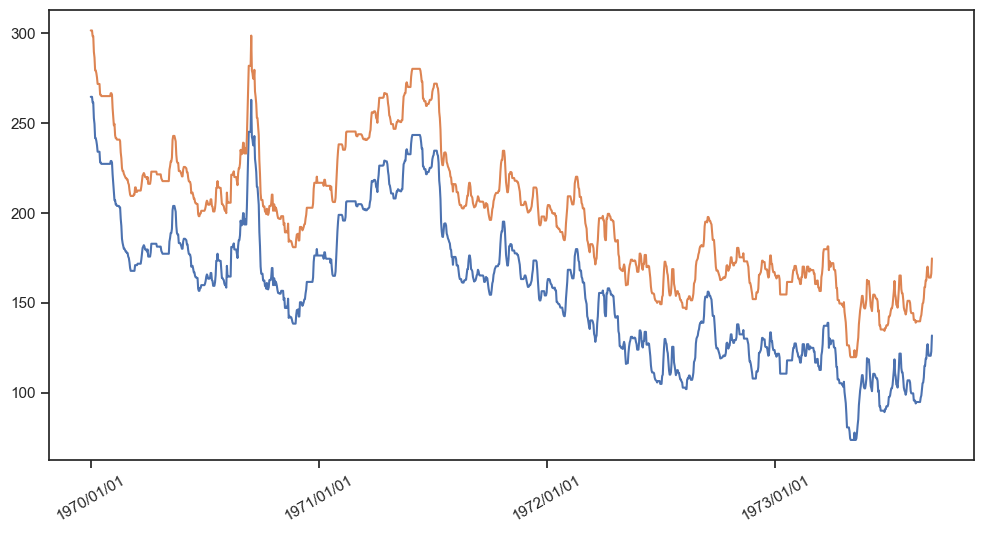

In [1122]:
from matplotlib import dates

train_data = eggs_price

x = train_data[train_data['FarmingMethod'] == 'Cage']
x = x[['ReferencePeriod', 'Price(euro/100kg)']]
y = train_data[train_data['FarmingMethod'] == 'Barn']
y = y[['ReferencePeriod', 'Price(euro/100kg)']]

# plt.rcParams["figure.figsize"] = [10.00, 5.50]
# plt.rcParams["figure.autolayout"] = True
fig, ax = plt.subplots()
plt.plot(np.array(x['ReferencePeriod']), np.array(x['Price(euro/100kg)']))
plt.plot(np.array(y['ReferencePeriod']), np.array(y['Price(euro/100kg)']))
ax.set_xticks(np.array(x['ReferencePeriod']))
ax.set_xticklabels(np.array(x['ReferencePeriod']), rotation=30, fontdict={'horizontalalignment': 'center'})
ax.xaxis.set_major_formatter(dates.DateFormatter('%Y/%m/%d'))
ax.xaxis.set_major_locator(dates.YearLocator())
plt.show()

### Merging cycles with eggs price

In [1123]:
cycleA = pd.merge(cycleA, eggs_price[eggs_price['FarmingMethod'] == "Barn"][['ReferencePeriod', 'Price(euro/100kg)']], left_on='Date of Laid', right_on='ReferencePeriod', how='outer')
cycleA.pop('ReferencePeriod')
cycleA['Price(euro/100kg)'] = cycleA['Price(euro/100kg)'].fillna(method='bfill')

cycleB = pd.merge(cycleB, eggs_price[eggs_price['FarmingMethod'] == "Barn"][['ReferencePeriod', 'Price(euro/100kg)']], left_on='Date of Laid', right_on='ReferencePeriod', how='outer')
cycleB.pop('ReferencePeriod')
cycleB['Price(euro/100kg)'] = cycleB['Price(euro/100kg)'].fillna(method='bfill')

cycleZ = pd.merge(cycleZ, eggs_price[eggs_price['FarmingMethod'] == "Barn"][['ReferencePeriod', 'Price(euro/100kg)']], left_on='Date of Laid', right_on='ReferencePeriod', how='outer')
cycleZ.pop('ReferencePeriod')
cycleZ['Price(euro/100kg)'] = cycleZ['Price(euro/100kg)'].fillna(method='bfill')

## Data preview

### Cycle A

In [1124]:
cycleA.head()

Arrival Chickens Date  Death  Chickens Date of Laid     Eggs     Laied  \
0            2018/07/19   10.0   42009.0   2018/09/01  31770.0  0.756267   
1            2018/07/19   11.0   41998.0   2018/09/02  31960.0  0.760989   
2            2018/07/19   11.0   41987.0   2018/09/03  33520.0  0.798342   
3            2018/07/19    8.0   41979.0   2018/09/04  35440.0  0.844232   
4            2018/07/19   11.0   41968.0   2018/09/05  35300.0  0.841117   

   Water   Feed Date of Selling  # Eggs sold (First quality)  \
0  100.0   97.0             NaN                          0.0   
1  101.0  105.5             NaN                          0.0   
2  104.5  102.0      2018/09/03                      87750.0   
3  107.0  119.5             NaN                          0.0   
4  110.0  113.0      2018/09/05                      66450.0   

   # Eggs sold (Second quality)  Price(euro/100kg)  
0                           0.0         211.402622  
1                           0.0         211.402622  
2                           0.0         211.402622  
3                           0.0         199.961848  
4                           0.0         199.961848

### Cycle B

In [1125]:
cycleB.head()

Arrival Chickens Date  Death  Chickens Date of Laid     Eggs     Laied  \
0            2020/08/09    8.0   42098.0   2020/09/24  34260.0  0.813815   
1            2020/08/09    9.0   42089.0   2020/09/25  35010.0  0.831809   
2            2020/08/09    4.0   42085.0   2020/09/26  35880.0  0.852560   
3            2020/08/09    6.0   42079.0   2020/09/27  36180.0  0.859811   
4            2020/08/09    6.0   42073.0   2020/09/28  37050.0  0.880612   

   Water   Feed Date of Selling  # Eggs sold (First quality)  \
0  129.0  102.0      2020/09/24                      33360.0   
1  128.0  101.0      2020/09/25                      34290.0   
2  130.0  113.0      2020/09/26                      35040.0   
3  133.0  112.0             NaN                          0.0   
4  136.0  117.0      2020/09/28                      71760.0   

   # Eggs sold (Second quality)  Price(euro/100kg)  
0                           0.0          221.53858  
1                           0.0          221.53858  
2                           0.0          221.53858  
3                           0.0          221.53858  
4                           0.0          221.53858

### Cycle Z

In [1126]:
cycleZ.head()

Arrival Chickens Date  Death  Chickens Date of Laid     Eggs     Laied  \
0            2016/11/17    6.0   42130.0   2017/01/08  30080.0  0.713981   
1            2016/11/17    9.0   42121.0   2017/01/09  31710.0  0.752831   
2            2016/11/17   13.0   42108.0   2017/01/10  33800.0  0.802698   
3            2016/11/17   10.0   42098.0   2017/01/11  34330.0  0.815478   
4            2016/11/17   12.0   42086.0   2017/01/12  34050.0  0.809058   

   Water  Feed Date of Selling  # Eggs sold (First quality)  \
0    NaN   NaN             NaN                          0.0   
1    NaN   NaN             NaN                      63960.0   
2    NaN   NaN             NaN                      42530.0   
3    NaN   NaN             NaN                      32220.0   
4    NaN   NaN             NaN                      32400.0   

   # Eggs sold (Second quality)  Price(euro/100kg)  
0                           0.0         196.775451  
1                           0.0         196.775451  
2                           0.0         196.775451  
3                           0.0         196.775451  
4                           0.0         196.775451

### Temperature data

In [1127]:
temperature_data.head()

Date  Avg_temp_value
0  2014/01/01             2.8
1  2014/01/02             4.1
2  2014/01/03             4.7
3  2014/01/04             6.0
4  2014/01/05             6.8

### Humidity data

In [1128]:
humidity_data.head()

Date  Avg_humidity_value
0  2014/01/01                70.5
1  2014/01/02                85.9
2  2014/01/03                99.9
3  2014/01/04                99.9
4  2014/01/05                99.9

### Eggs price

In [1129]:
eggs_price.head()

ReferencePeriod FarmingMethod  Price(euro/100kg)
0      2022/11/07          Cage             264.68
1      2022/11/07          Barn             301.59
2      2022/10/31          Cage             264.68
3      2022/10/31          Barn             301.59
4      2022/10/24          Cage             264.68

## Data join: chicken's data with meteorological data

In [1130]:
meteorological_data = pd.merge(temperature_data, humidity_data, on='Date')

weather_join_chickens_a = pd.merge(cycleA, meteorological_data, left_on='Date of Laid', right_on='Date', how='inner')

weather_join_chickens_b = pd.merge(cycleB, meteorological_data, left_on='Date of Laid', right_on='Date', how='inner')

weather_join_chickens_z = pd.merge(cycleZ, meteorological_data, left_on='Date of Laid', right_on='Date', how='inner')

In [1131]:
# Function that takes in input a pandas df with dates and returns a pandas df of seasons
def date_to_season (dates_dataframe):
    
    dateOffset = ( pd.to_datetime(dates_dataframe).dt.month*100 + pd.to_datetime(dates_dataframe).dt.day - 320 ) % 1300

    seasons = pd.cut(dateOffset, [0, 300, 602, 900, 1300], labels=['spring', 'summer', 'autumn', 'winter'])
    
    return seasons

weather_join_chickens_a['Season'] = date_to_season(weather_join_chickens_a['Date'])
weather_join_chickens_b['Season'] = date_to_season(weather_join_chickens_b['Date'])
weather_join_chickens_z['Season'] = date_to_season(weather_join_chickens_z['Date'])

## Data normalization

In [1132]:
# Apply min-max normalization techniques

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

for column in weather_join_chickens_a:
    if(column!="Arrival Chickens Date" and column!="Date of Laid" and column!="Date of Selling" and column!="Date" and column!="Season" and column!='FarmingMethod'):
        weather_join_chickens_a[column] = scaler.fit_transform(weather_join_chickens_a[column].values.reshape(-1, 1))        
for column in weather_join_chickens_b:
    if(column!="Arrival Chickens Date" and column!="Date of Laid" and column!="Date of Selling" and column!="Date" and column!="Season" and column!='FarmingMethod'):
        weather_join_chickens_b[column] = scaler.fit_transform(weather_join_chickens_b[column].values.reshape(-1, 1))
for column in weather_join_chickens_z:
    if(column!="Arrival Chickens Date" and column!="Date of Laid" and column!="Date of Selling" and column!="Date" and column!="Season" and column!='FarmingMethod'):
        weather_join_chickens_z[column] = scaler.fit_transform(weather_join_chickens_z[column].values.reshape(-1, 1))

C:\Users\fcami\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_data.py:464: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\fcami\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_data.py:465: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
C:\Users\fcami\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_data.py:464: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\fcami\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_data.py:465: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis

## Data inspection

### Choosing features

In [1133]:
# input (x) and output (y) features
every_feature = weather_join_chickens_a.columns
input_features = ['Water', 'Feed', 'Avg_temp_value', 'Avg_humidity_value', 'Season']
output_features = ['Death','Eggs']

### Cycle A

C:\Users\fcami\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


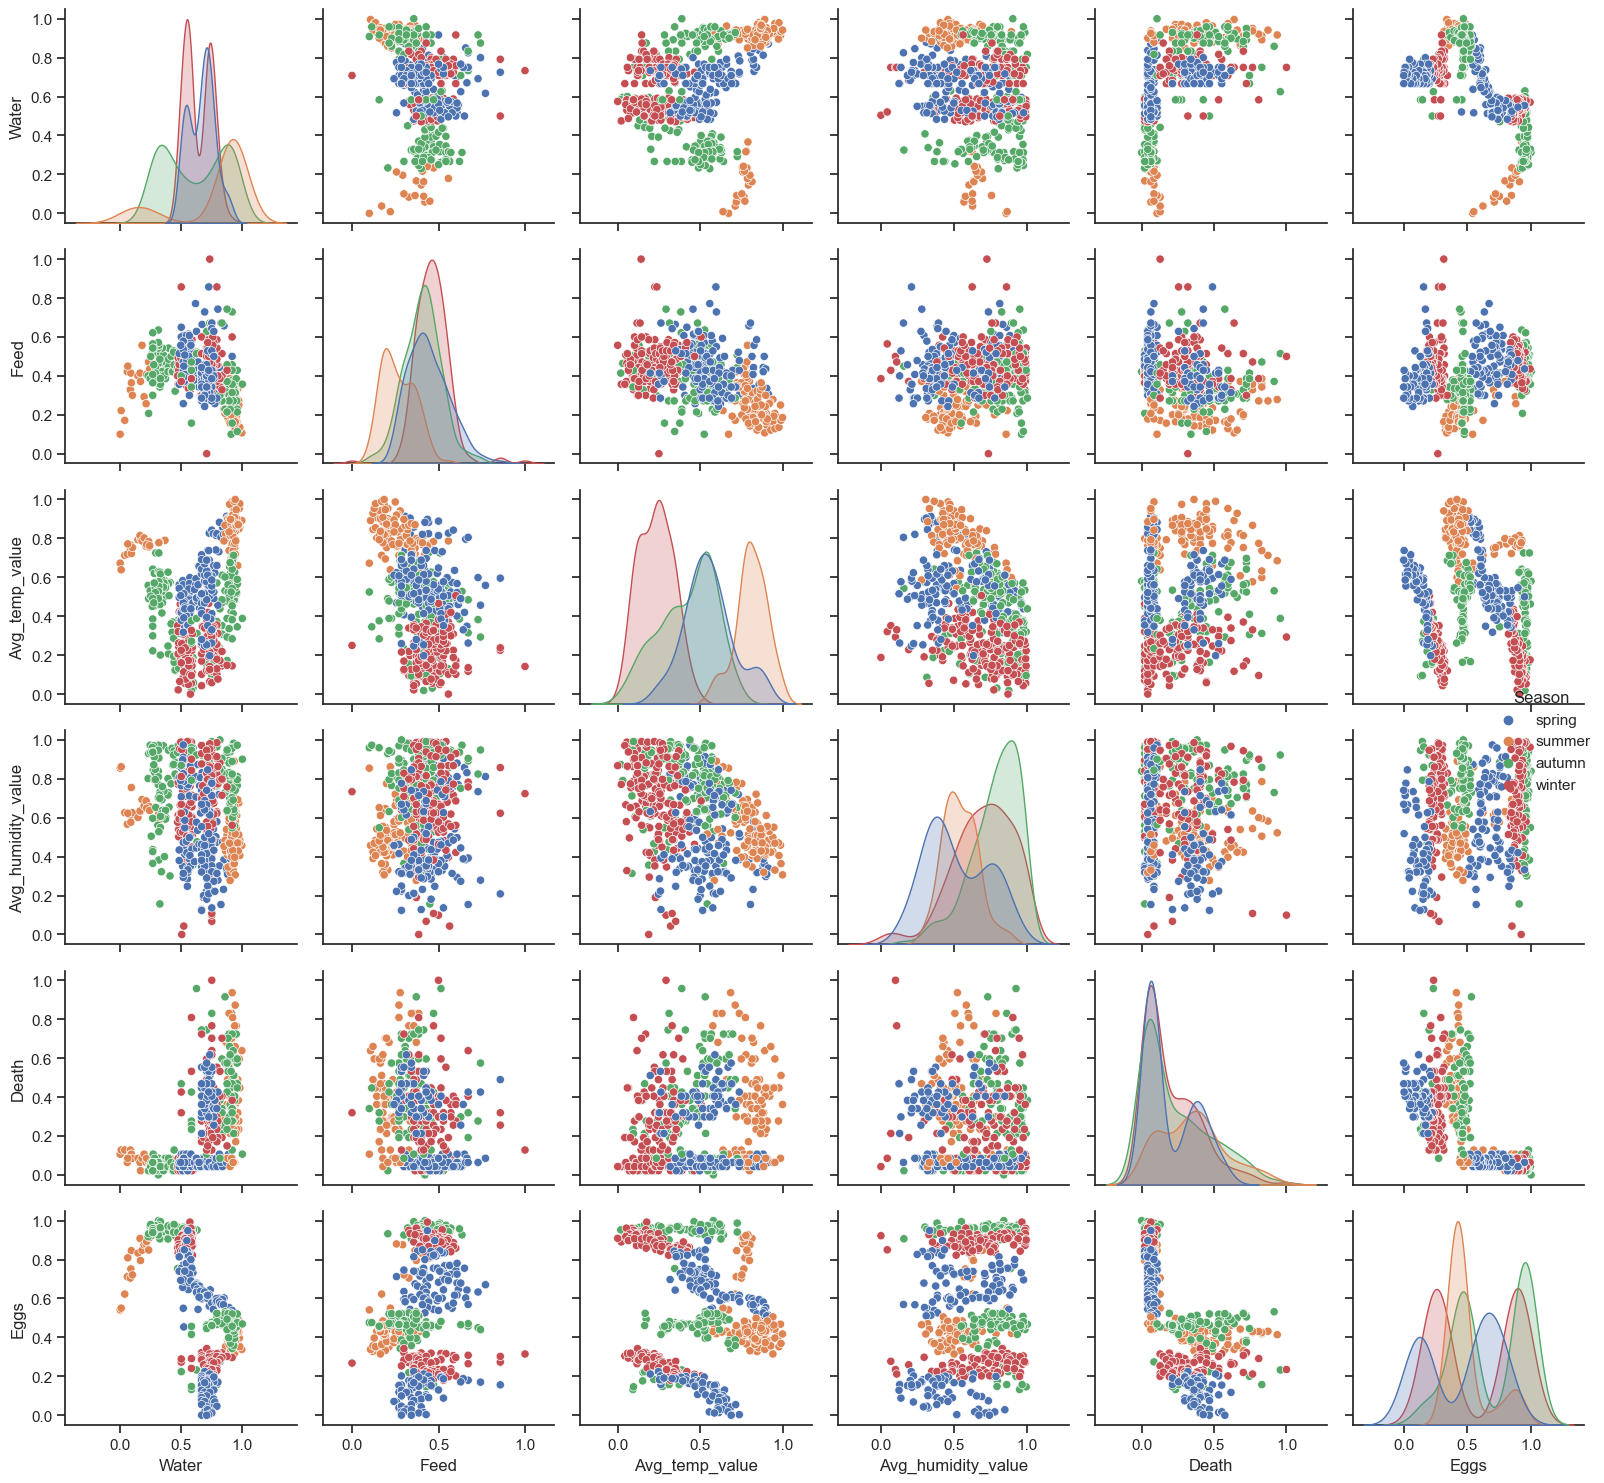

C:\Users\fcami\AppData\Local\Temp\ipykernel_7692\3971686682.py:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(weather_join_chickens_a[input_features + output_features].corr(), annot=True)
C:\Users\fcami\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


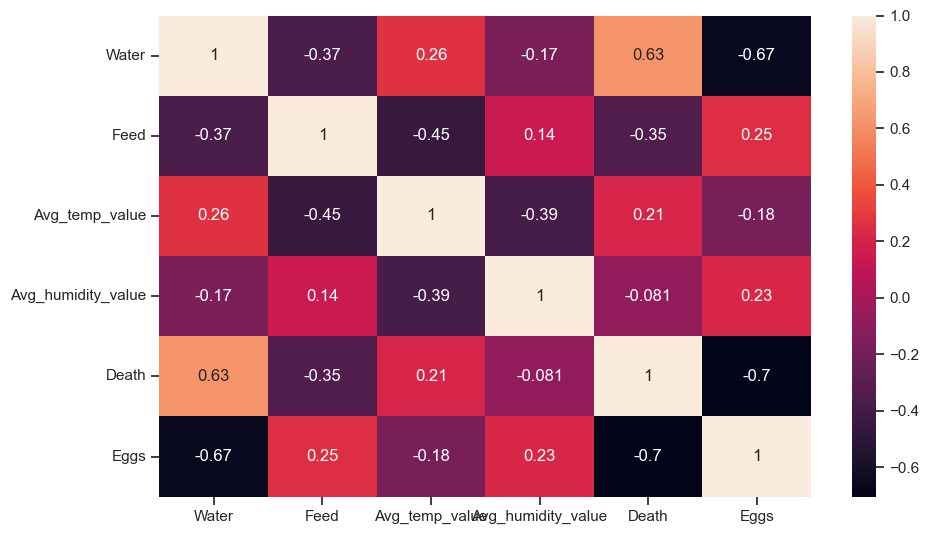

In [1134]:
# pair plot cycle A
#norm_a = np.array()
sns.set(style="ticks", color_codes=True)
sns.pairplot(weather_join_chickens_a[input_features + output_features], hue='Season')
plt.show()

# heatmap cycle A
sns.heatmap(weather_join_chickens_a[input_features + output_features].corr(), annot=True)
plt.show()

### Cycle B

C:\Users\fcami\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


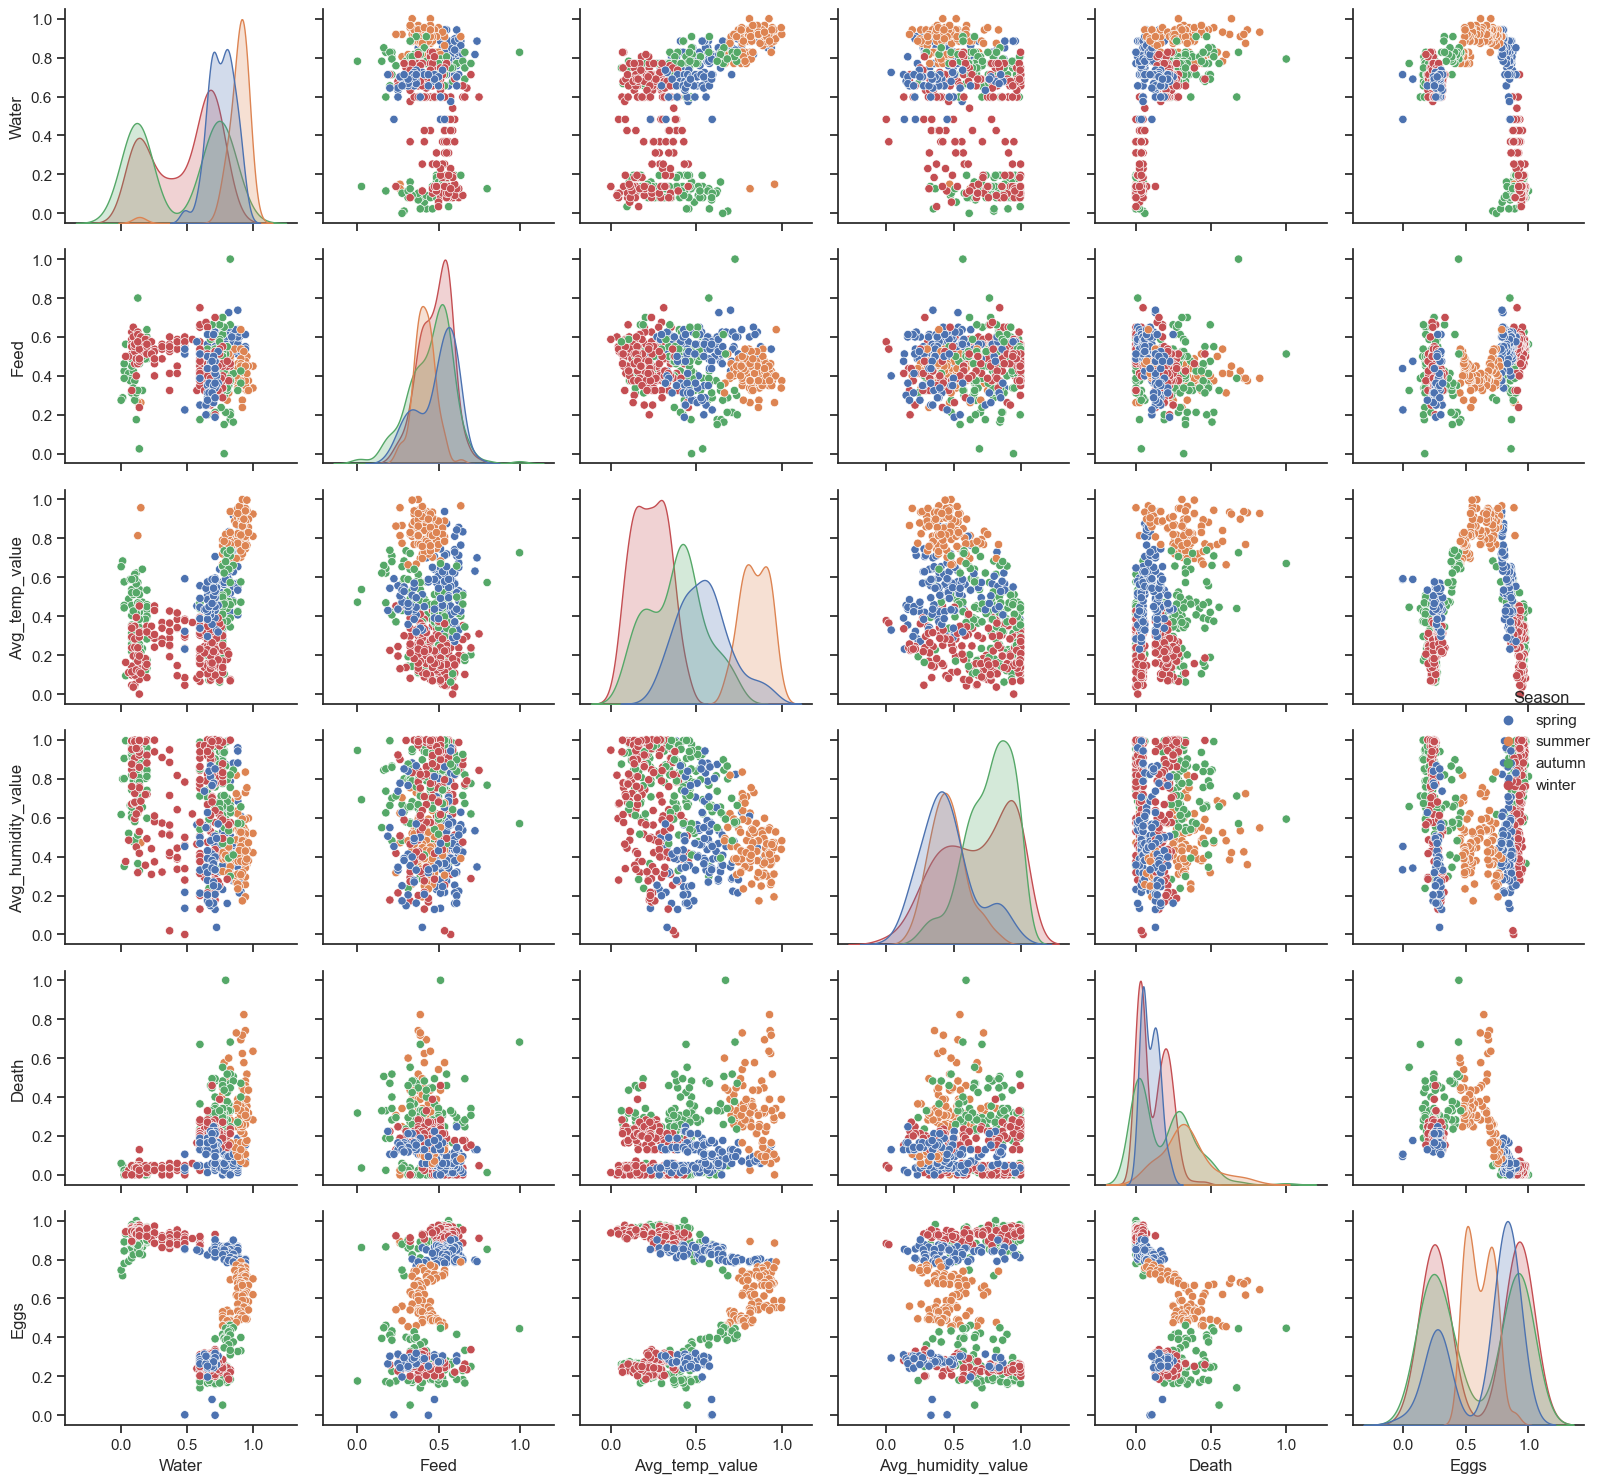

C:\Users\fcami\AppData\Local\Temp\ipykernel_7692\1139925268.py:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(weather_join_chickens_b[input_features + output_features].corr(), annot=True)
C:\Users\fcami\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


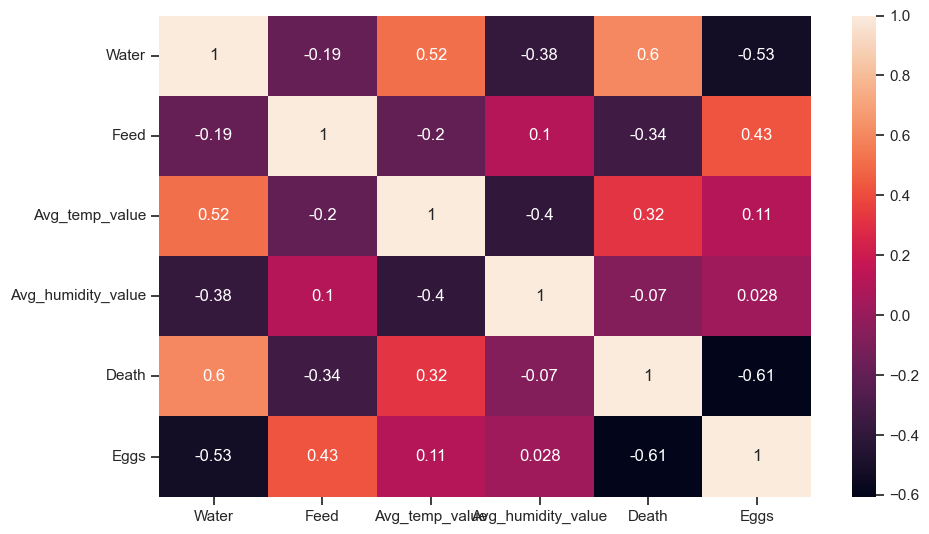

In [1135]:
# pair plot cycle B
sns.set(style="ticks", color_codes=True)
sns.pairplot(weather_join_chickens_b[input_features + output_features], hue='Season')
plt.show()

# heatmap cycle B
sns.heatmap(weather_join_chickens_b[input_features + output_features].corr(), annot=True)
plt.show()

### Cycle Z

C:\Users\fcami\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


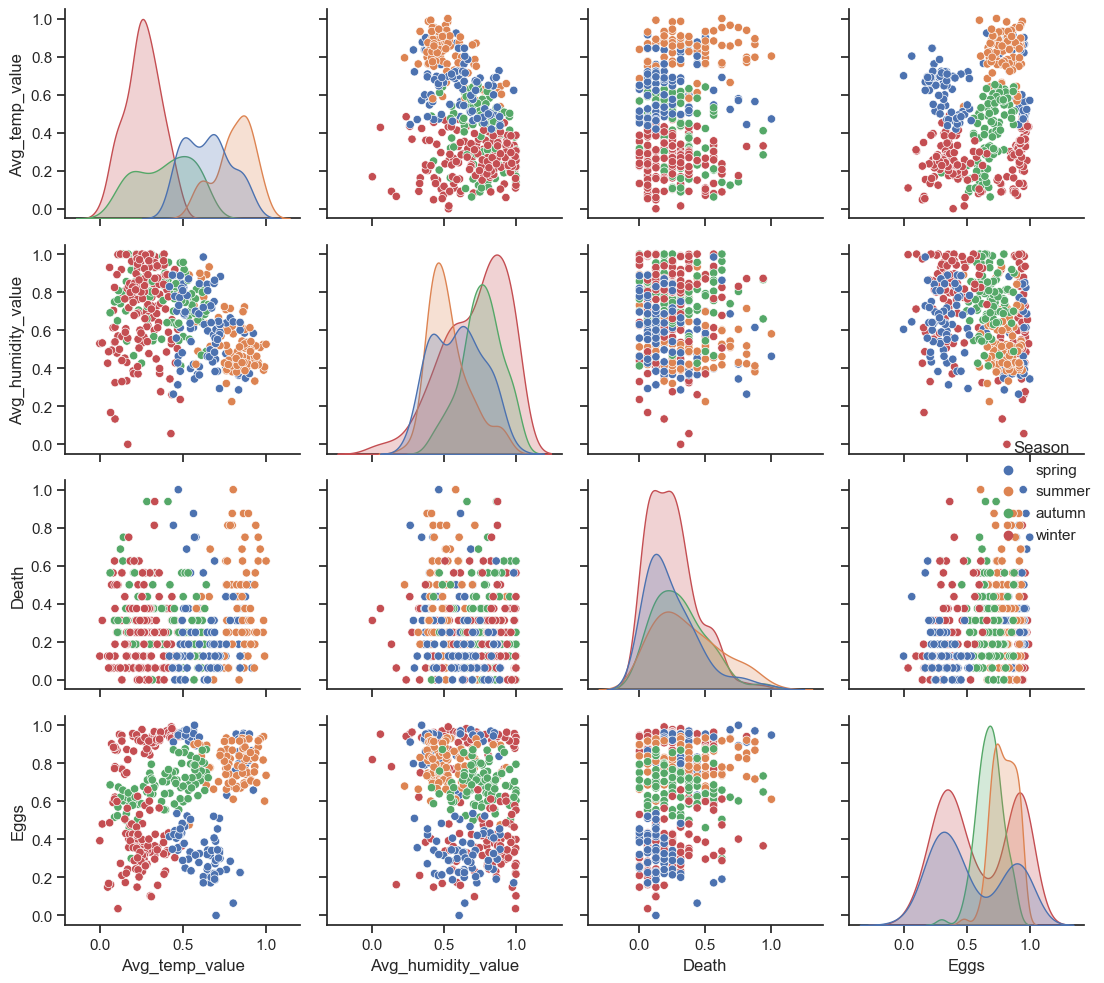

C:\Users\fcami\AppData\Local\Temp\ipykernel_7692\606239845.py:9: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(weather_join_chickens_z[input_features_z + output_features].corr(), annot=True)
C:\Users\fcami\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


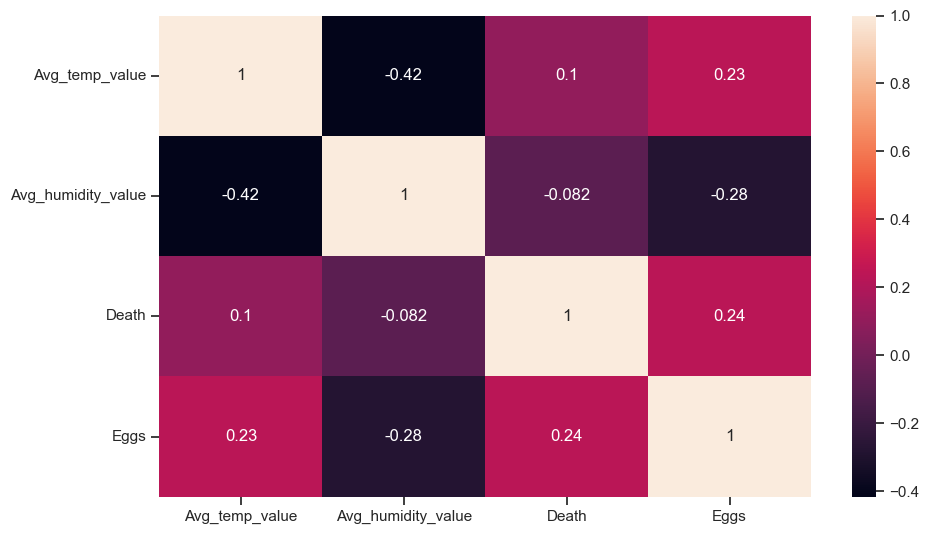

In [1136]:
input_features_z = ['Avg_temp_value', 'Avg_humidity_value', 'Season']

# pair plot cycle Z
sns.set(style="ticks", color_codes=True)
sns.pairplot(weather_join_chickens_z[input_features_z + output_features], hue='Season')
plt.show()

# heatmap cycle Z
sns.heatmap(weather_join_chickens_z[input_features_z + output_features].corr(), annot=True)
plt.show()

# Cycle unification - a and b

In [1137]:
def add_cycle_ID_column(df: pd.DataFrame, cycle_name: str):
    df['Cycle_ID'] = cycle_name
    return df

a = add_cycle_ID_column(weather_join_chickens_a, 'a')
b = add_cycle_ID_column(weather_join_chickens_b, 'b')

a_b = pd.concat([a, b], axis=0)

a_b

Arrival Chickens Date     Death  Chickens Date of Laid      Eggs  \
0              2018/07/19  0.106383  1.000000   2018/09/01  0.541493   
1              2018/07/19  0.127660  0.998914   2018/09/02  0.550301   
2              2018/07/19  0.127660  0.997829   2018/09/03  0.622624   
3              2018/07/19  0.063830  0.997039   2018/09/04  0.711637   
4              2018/07/19  0.127660  0.995954   2018/09/05  0.705146   
..                    ...       ...       ...          ...       ...   
569            2020/08/09  0.152941  0.005860   2022/04/28  0.274517   
570            2020/08/09  0.164706  0.004159   2022/04/29  0.252510   
571            2020/08/09  0.176471  0.002363   2022/04/30  0.081081   
572            2020/08/09  0.094118  0.001229   2022/05/01  0.000000   
573            2020/08/09  0.105882  0.000000   2022/05/02  0.002317   

        Laied     Water      Feed Date of Selling  \
0    0.334615  0.000000  0.100000             NaN   
1    0.347074  0.008333  0.221429             NaN   
2    0.445629  0.037500  0.171429      2018/09/03   
3    0.566705  0.058333  0.421429             NaN   
4    0.558487  0.083333  0.328571      2018/09/05   
..        ...       ...       ...             ...   
569  0.478958  0.701149  0.500000             NaN   
570  0.445143  0.655172  0.437500             NaN   
571  0.176247  0.689655  0.475000             NaN   
572  0.049045  0.712644  0.437500             NaN   
573  0.053086  0.482759  0.225000      2022/05/02   

     # Eggs sold (First quality)  # Eggs sold (Second quality)  \
0                       0.000000                           0.0   
1                       0.000000                           0.0   
2                       0.726347                           0.0   
3                       0.000000                           0.0   
4                       0.550037                           0.0   
..                           ...                           ...   
569                     0.000000                           0.0   
570                     0.000000                           0.0   
571                     0.000000                           0.0   
572                     0.000000                           0.0   
573                     0.768868                           0.0   

     Price(euro/100kg)        Date  Avg_temp_value  Avg_humidity_value  \
0             0.127032  2018/09/01        0.672840            0.854676   
1             0.127032  2018/09/02        0.638889            0.861871   
2             0.127032  2018/09/03        0.712963            0.625899   
3             0.016291  2018/09/04        0.719136            0.566906   
4             0.016291  2018/09/05        0.750000            0.612950   
..                 ...         ...             ...                 ...   
569           0.971838  2022/04/28        0.543974            0.363104   
570           0.971838  2022/04/29        0.576547            0.317716   
571           0.971838  2022/04/30        0.589577            0.341142   
572           0.971838  2022/05/01        0.589577            0.332357   
573           0.971838  2022/05/02        0.592834            0.452416   

     Season Cycle_ID  
0    summer        a  
1    summer        a  
2    summer        a  
3    summer        a  
4    summer        a  
..      ...      ...  
569  spring        b  
570  spring        b  
571  spring        b  
572  spring        b  
573  spring        b  

[1196 rows x 17 columns]

## Cycle unification pairplot

C:\Users\fcami\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


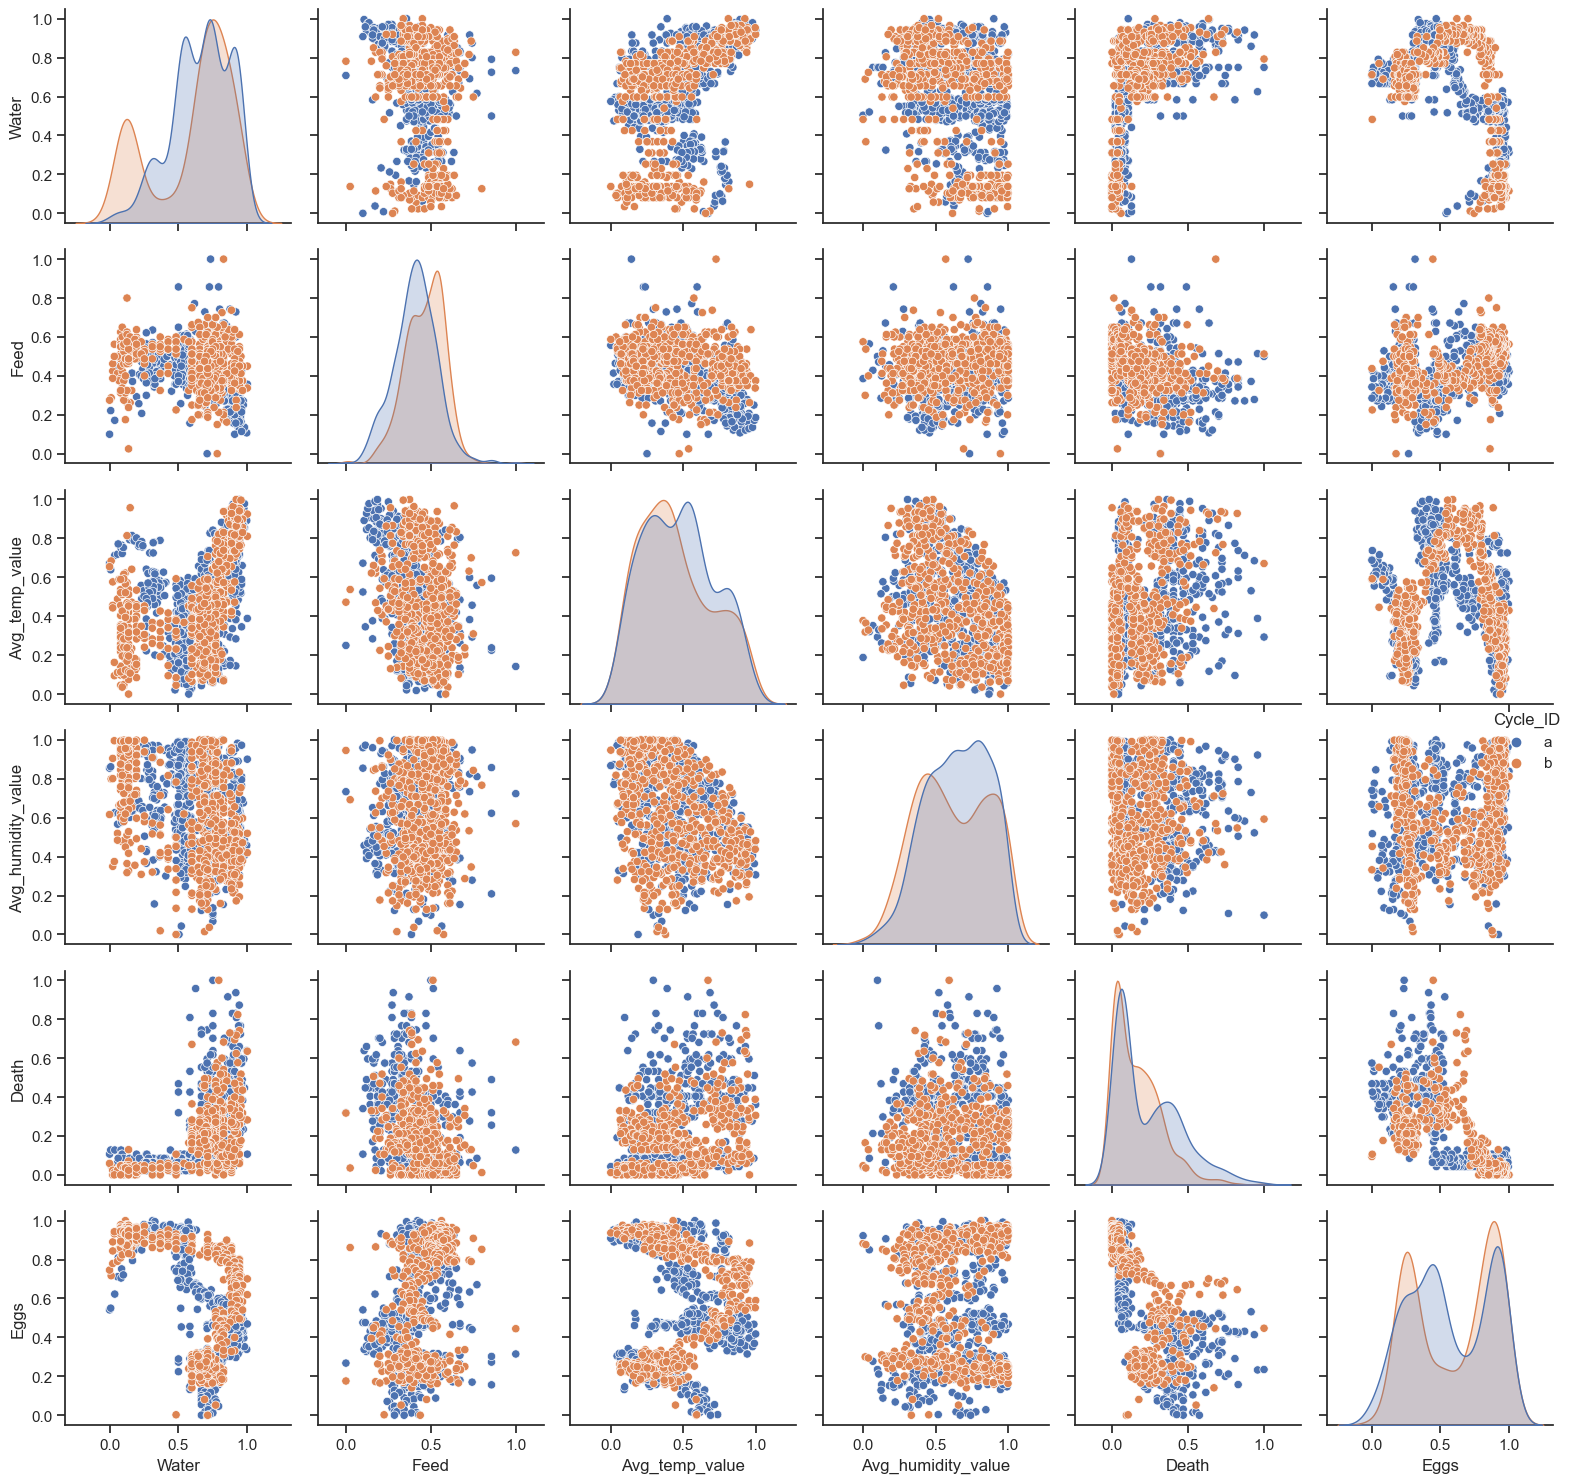

In [1138]:
# pair plot
sns.set(style="ticks", color_codes=True)
sns.pairplot(a_b[input_features + output_features + ['Cycle_ID']], hue='Cycle_ID')
plt.show()

## Cycle unification - a and b and z

Since cycle z has missing features these will be deleted.

In [1139]:
def add_cycle_ID_column(df: pd.DataFrame, cycle_name: str):
    df['Cycle_ID'] = cycle_name
    return df

a = add_cycle_ID_column(weather_join_chickens_a, 'a')
b = add_cycle_ID_column(weather_join_chickens_b, 'b')
z = add_cycle_ID_column(weather_join_chickens_z, 'z')

a

# a.pop('Water')
# a.pop('Feed')
# a.pop('Water')
# a.pop('Date of Selling')

abz = pd.concat([a, b, z], axis=0)
abz.pop('Water')
abz.pop('Feed')
abz.pop('Date of Selling')
abz

Arrival Chickens Date     Death  Chickens Date of Laid      Eggs  \
0              2018/07/19  0.106383  1.000000   2018/09/01  0.541493   
1              2018/07/19  0.127660  0.998914   2018/09/02  0.550301   
2              2018/07/19  0.127660  0.997829   2018/09/03  0.622624   
3              2018/07/19  0.063830  0.997039   2018/09/04  0.711637   
4              2018/07/19  0.127660  0.995954   2018/09/05  0.705146   
..                    ...       ...       ...          ...       ...   
432            2016/11/17  0.625000  0.007206   2018/05/23  0.191042   
433            2016/11/17  0.312500  0.005114   2018/05/24  0.284943   
434            2016/11/17  0.437500  0.002557   2018/05/25  0.064760   
435            2016/11/17  0.125000  0.001162   2018/05/26  0.226659   
436            2016/11/17  0.062500  0.000000   2018/05/27  0.225580   

        Laied  # Eggs sold (First quality)  # Eggs sold (Second quality)  \
0    0.334615                     0.000000                           0.0   
1    0.347074                     0.000000                           0.0   
2    0.445629                     0.726347                           0.0   
3    0.566705                     0.000000                           0.0   
4    0.558487                     0.550037                           0.0   
..        ...                          ...                           ...   
432  0.242417                     0.000000                           0.0   
433  0.357980                     0.182927                           0.0   
434  0.088437                     0.000000                           0.0   
435  0.287311                     0.182820                           0.0   
436  0.286223                     0.000000                           0.0   

     Price(euro/100kg)        Date  Avg_temp_value  Avg_humidity_value  \
0             0.127032  2018/09/01        0.672840            0.854676   
1             0.127032  2018/09/02        0.638889            0.861871   
2             0.127032  2018/09/03        0.712963            0.625899   
3             0.016291  2018/09/04        0.719136            0.566906   
4             0.016291  2018/09/05        0.750000            0.612950   
..                 ...         ...             ...                 ...   
432           1.000000  2018/05/23        0.690265            0.862553   
433           1.000000  2018/05/24        0.784661            0.664797   
434           1.000000  2018/05/25        0.802360            0.643759   
435           1.000000  2018/05/26        0.843658            0.600281   
436           1.000000  2018/05/27        0.843658            0.640954   

     Season Cycle_ID  
0    summer        a  
1    summer        a  
2    summer        a  
3    summer        a  
4    summer        a  
..      ...      ...  
432  spring        z  
433  spring        z  
434  spring        z  
435  spring        z  
436  spring        z  

[1633 rows x 14 columns]

C:\Users\fcami\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


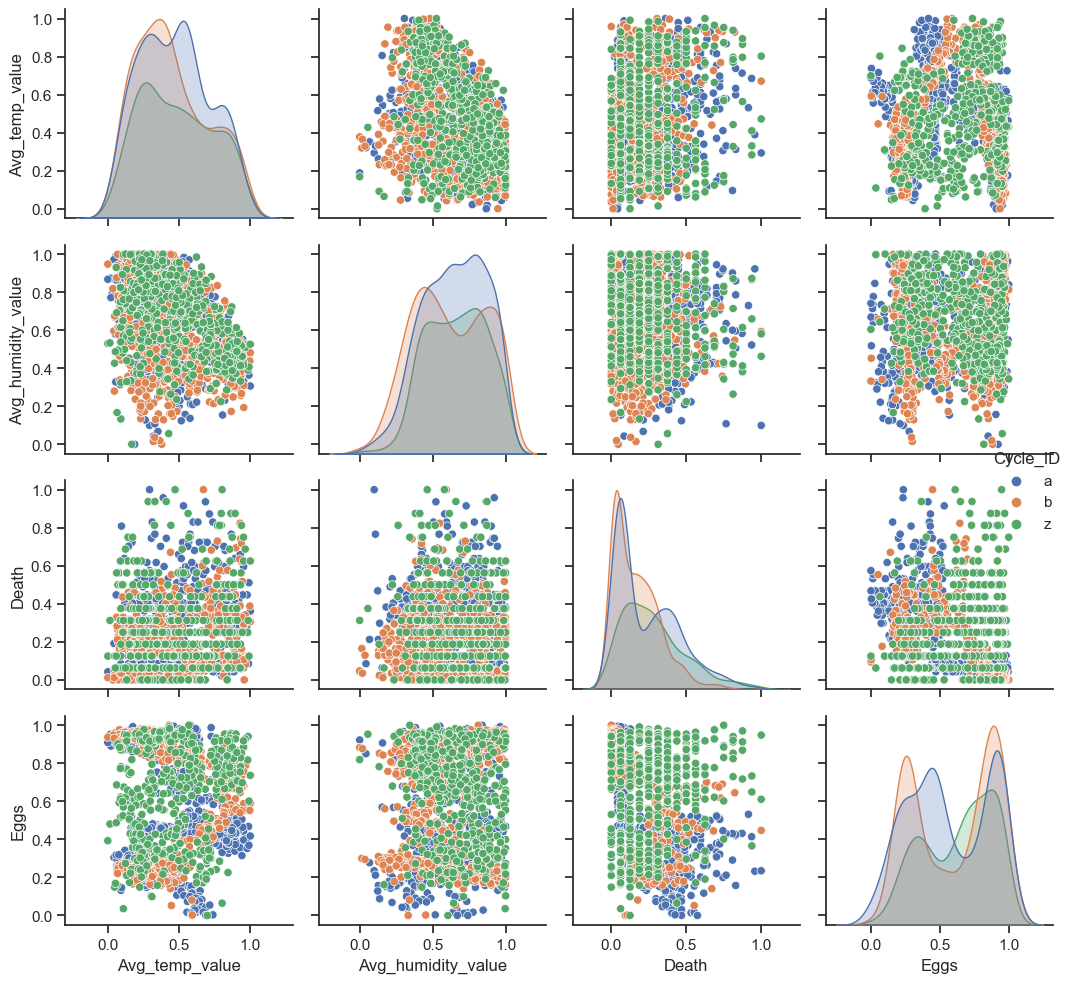

In [1140]:
# pair plot

input_features_abz = ['Avg_temp_value', 'Avg_humidity_value', 'Season']
output_features_abz = ['Death','Eggs']

sns.set(style="ticks", color_codes=True)
sns.pairplot(abz[input_features_abz + output_features_abz + ['Cycle_ID']], hue='Cycle_ID')
plt.show()